In [20]:
import pandas as pd
import numpy as np
import missingno as msno
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import root_mean_squared_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

import mlflow

In [21]:
mlflow.set_experiment("salary_prediction")

<Experiment: artifact_location='file:///c:/Users/GRETA/Documents/GitHub/MLOps/Jean/mlruns/175072019376251501', creation_time=1713789777093, experiment_id='175072019376251501', last_update_time=1713789777093, lifecycle_stage='active', name='salary_prediction', tags={}>

In [22]:
# The initial dataset has been downloaded on the data folder.
# We open it with pandas

df = pd.read_csv('data/ds_salaries.csv')

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3755 entries, 0 to 3754
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   work_year           3755 non-null   int64 
 1   experience_level    3755 non-null   object
 2   employment_type     3755 non-null   object
 3   job_title           3755 non-null   object
 4   salary              3755 non-null   int64 
 5   salary_currency     3755 non-null   object
 6   salary_in_usd       3755 non-null   int64 
 7   employee_residence  3755 non-null   object
 8   remote_ratio        3755 non-null   int64 
 9   company_location    3755 non-null   object
 10  company_size        3755 non-null   object
dtypes: int64(4), object(7)
memory usage: 322.8+ KB


In [24]:
df.sample(10)

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
1252,2023,MI,FT,Data Scientist,120000,USD,120000,US,0,US,M
744,2023,SE,FT,Data Scientist,70000,USD,70000,US,0,US,M
1535,2023,SE,FT,Data Engineer,226700,USD,226700,US,0,US,M
2841,2022,SE,FT,Data Scientist,136994,USD,136994,US,100,US,M
3364,2022,SE,FT,Data Analyst,170000,USD,170000,US,100,US,M
2704,2022,SE,FT,Machine Learning Engineer,140000,USD,140000,CA,0,CA,M
2498,2022,SE,FT,Machine Learning Engineer,204500,USD,204500,US,0,US,M
1772,2023,SE,FT,Data Analyst,155000,USD,155000,US,100,US,M
2119,2021,SE,FT,Data Analyst,115000,USD,115000,US,100,US,S
547,2023,SE,FT,Data Engineer,167500,USD,167500,US,0,US,M


In [25]:
# list the different values of the column "salary_currency"
df['salary_currency'].value_counts()

salary_currency
USD    3224
EUR     236
GBP     161
INR      60
CAD      25
AUD       9
SGD       6
BRL       6
PLN       5
CHF       4
HUF       3
DKK       3
JPY       3
TRY       3
THB       2
ILS       1
HKD       1
CZK       1
MXN       1
CLP       1
Name: count, dtype: int64

In [26]:
# delete rows with salary_currency different from ['USD', 'EUR', 'GBP']
df = df[df['salary_currency'].isin(['USD', 'EUR', 'GBP'])]

In [27]:
usd_to_eur = 0.94  # 1 USD = 0.94 EUR
gbp_to_eur = 1.14  # 1 GBP = 1.14 EUR 
inr_to_eur = 0.011 # 1 INR = 0.011 EUR
cad_to_eur = 0.70  # 1 CAD = 0.70 EUR
aud_to_eur = 0.64  # 1 AUD = 0.64 EUR
sgd_to_eur = 0.71  # 1 SGD = 0.71 EUR [[10]]
brl_to_eur = 0.18  # 1 BRL = 0.18 EUR [[1]]
pln_to_eur = 0.22  # 1 PLN = 0.22 EUR [[2]] 
chf_to_eur = 1.01  # 1 CHF = 1.01 EUR
huf_to_eur = 0.0027 # 1 HUF = 0.0027 EUR [[2]]
dkk_to_eur = 0.13  # 1 DKK = 0.13 EUR [[2]]
jpy_to_eur = 0.0073 # 1 JPY = 0.0073 EUR [[2]]
try_to_eur = 0.051 # 1 TRY = 0.051 EUR [[2]]
thb_to_eur = 0.027 # 1 THB = 0.027 EUR 
ils_to_eur = 0.26  # 1 ILS = 0.26 EUR
hkd_to_eur = 0.12  # 1 HKD = 0.12 EUR
czk_to_eur = 0.041 # 1 CZK = 0.041 EUR [[2]]
mxn_to_eur = 0.052 # 1 MXN = 0.052 EUR
clp_to_eur = 0.0011 # 1 CLP = 0.0011 EUR


In [28]:
# create a new column "salary_eur" that contains the salary in EUR
df['salary_eur'] = df['salary']

# set type of df['salary_eur'] to float
df['salary_eur'] = df['salary_eur'].astype(float)

df.loc[df['salary_currency'] == 'USD', 'salary_eur'] = df['salary'] * usd_to_eur
df.loc[df['salary_currency'] == 'GBP', 'salary_eur'] = df['salary'] * gbp_to_eur
df.loc[df['salary_currency'] == 'INR', 'salary_eur'] = df['salary'] * inr_to_eur
df.loc[df['salary_currency'] == 'CAD', 'salary_eur'] = df['salary'] * cad_to_eur
df.loc[df['salary_currency'] == 'AUD', 'salary_eur'] = df['salary'] * aud_to_eur
df.loc[df['salary_currency'] == 'SGD', 'salary_eur'] = df['salary'] * sgd_to_eur
df.loc[df['salary_currency'] == 'BRL', 'salary_eur'] = df['salary'] * brl_to_eur
df.loc[df['salary_currency'] == 'PLN', 'salary_eur'] = df['salary'] * pln_to_eur
df.loc[df['salary_currency'] == 'CHF', 'salary_eur'] = df['salary'] * chf_to_eur
df.loc[df['salary_currency'] == 'HUF', 'salary_eur'] = df['salary'] * huf_to_eur
df.loc[df['salary_currency'] == 'DKK', 'salary_eur'] = df['salary'] * dkk_to_eur
df.loc[df['salary_currency'] == 'JPY', 'salary_eur'] = df['salary'] * jpy_to_eur
df.loc[df['salary_currency'] == 'TRY', 'salary_eur'] = df['salary'] * try_to_eur
df.loc[df['salary_currency'] == 'THB', 'salary_eur'] = df['salary'] * thb_to_eur
df.loc[df['salary_currency'] == 'ILS', 'salary_eur'] = df['salary'] * ils_to_eur
df.loc[df['salary_currency'] == 'HKD', 'salary_eur'] = df['salary'] * hkd_to_eur
df.loc[df['salary_currency'] == 'CZK', 'salary_eur'] = df['salary'] * czk_to_eur
df.loc[df['salary_currency'] == 'MXN', 'salary_eur'] = df['salary'] * mxn_to_eur
df.loc[df['salary_currency'] == 'CLP', 'salary_eur'] = df['salary'] * clp_to_eur

In [29]:
def get_salary_range(salary):
    return round(int(salary / 10000), 1)

df['salary_range'] = df['salary_eur'].apply(get_salary_range)

In [30]:
df.sample(10)

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size,salary_eur,salary_range
2474,2022,SE,FT,Machine Learning Engineer,116100,USD,116100,CA,100,CA,M,109134.00,10
2565,2022,SE,FT,Data Analyst,236600,USD,236600,US,100,US,M,222404.00,22
880,2023,SE,FT,Data Analyst,95000,USD,95000,US,0,US,M,89300.00,8
3638,2021,MI,FT,Data Scientist,21600,EUR,25532,RS,100,DE,S,21600.00,2
3487,2021,MI,FT,Data Scientist,82500,USD,82500,US,100,US,S,77550.00,7
3350,2022,MI,FT,Data Engineer,206699,USD,206699,US,0,US,M,194297.06,19
16,2023,SE,FT,Data Modeler,90700,USD,90700,US,0,US,M,85258.00,8
2143,2022,SE,FT,Data Scientist,140000,USD,140000,US,100,US,M,131600.00,13
2012,2022,MI,FT,Data Analyst,45000,GBP,55410,GB,0,GB,M,51300.00,5
3291,2022,SE,FT,Data Analyst,61300,USD,61300,CA,100,CA,M,57622.00,5


In [32]:
# drop columns "salary" and "salary_currency" and "salary_in_usd"
df = df.drop(columns=['salary', 'salary_currency', 'salary_in_usd', 'salary_eur'])

In [33]:
df.sample(10)

,work_year,experience_level,employment_type,job_title,employee_residence,remote_ratio,company_location,company_size,salary_range
1056,2023,SE,FT,Data Analyst,US,0,US,M,21
2815,2022,MI,FT,Data Operations Engineer,US,100,US,M,5
155,2023,MI,FT,Business Data Analyst,US,50,US,L,9
2366,2022,SE,FT,Machine Learning Engineer,US,0,US,M,19
3226,2022,MI,FT,Data Engineer,US,0,US,M,7
2836,2022,EN,FT,Data Scientist,US,0,US,M,8
1022,2023,SE,FT,Research Engineer,DE,100,DE,S,10
1556,2023,SE,FT,BI Developer,US,100,US,M,13
2039,2022,SE,FT,Data Specialist,US,0,US,M,10
248,2023,SE,FT,Analytics Engineer,US,100,US,M,10


<Axes: >

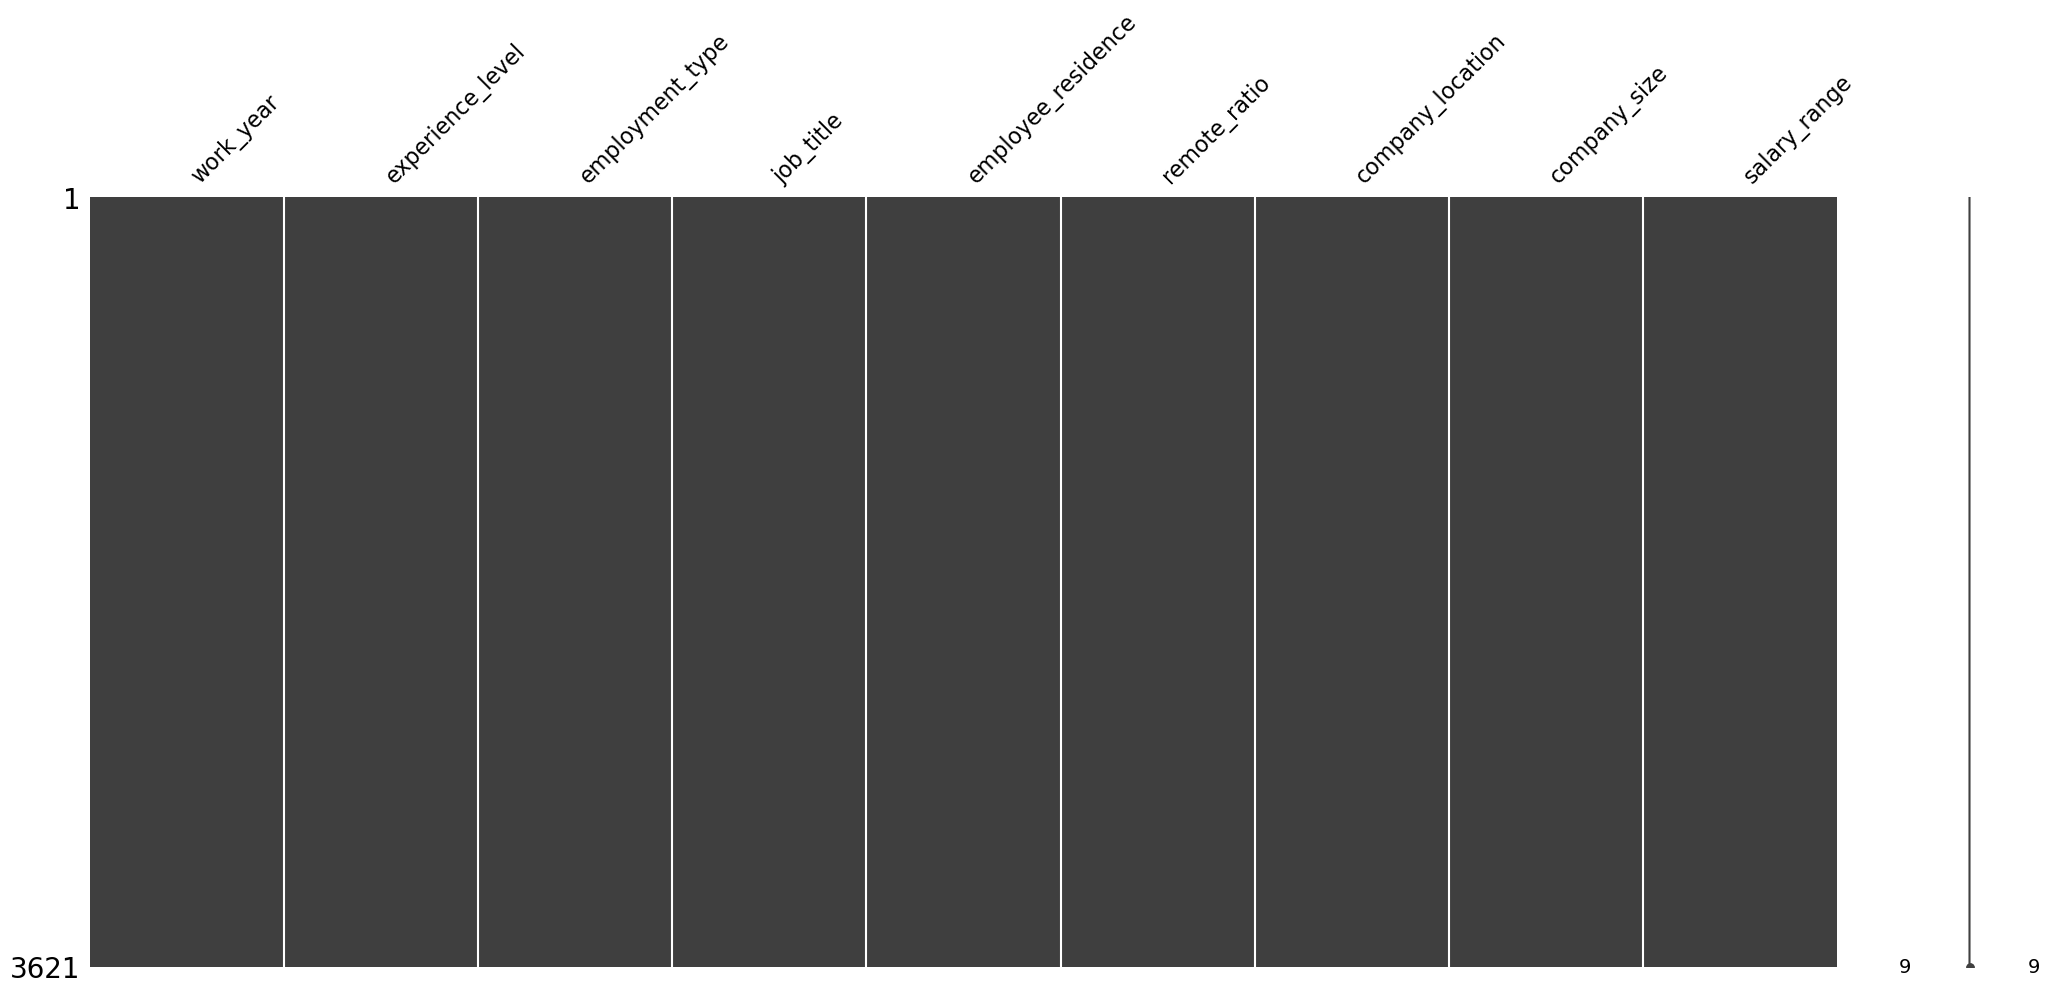

In [34]:
msno.matrix(df)

<Axes: >

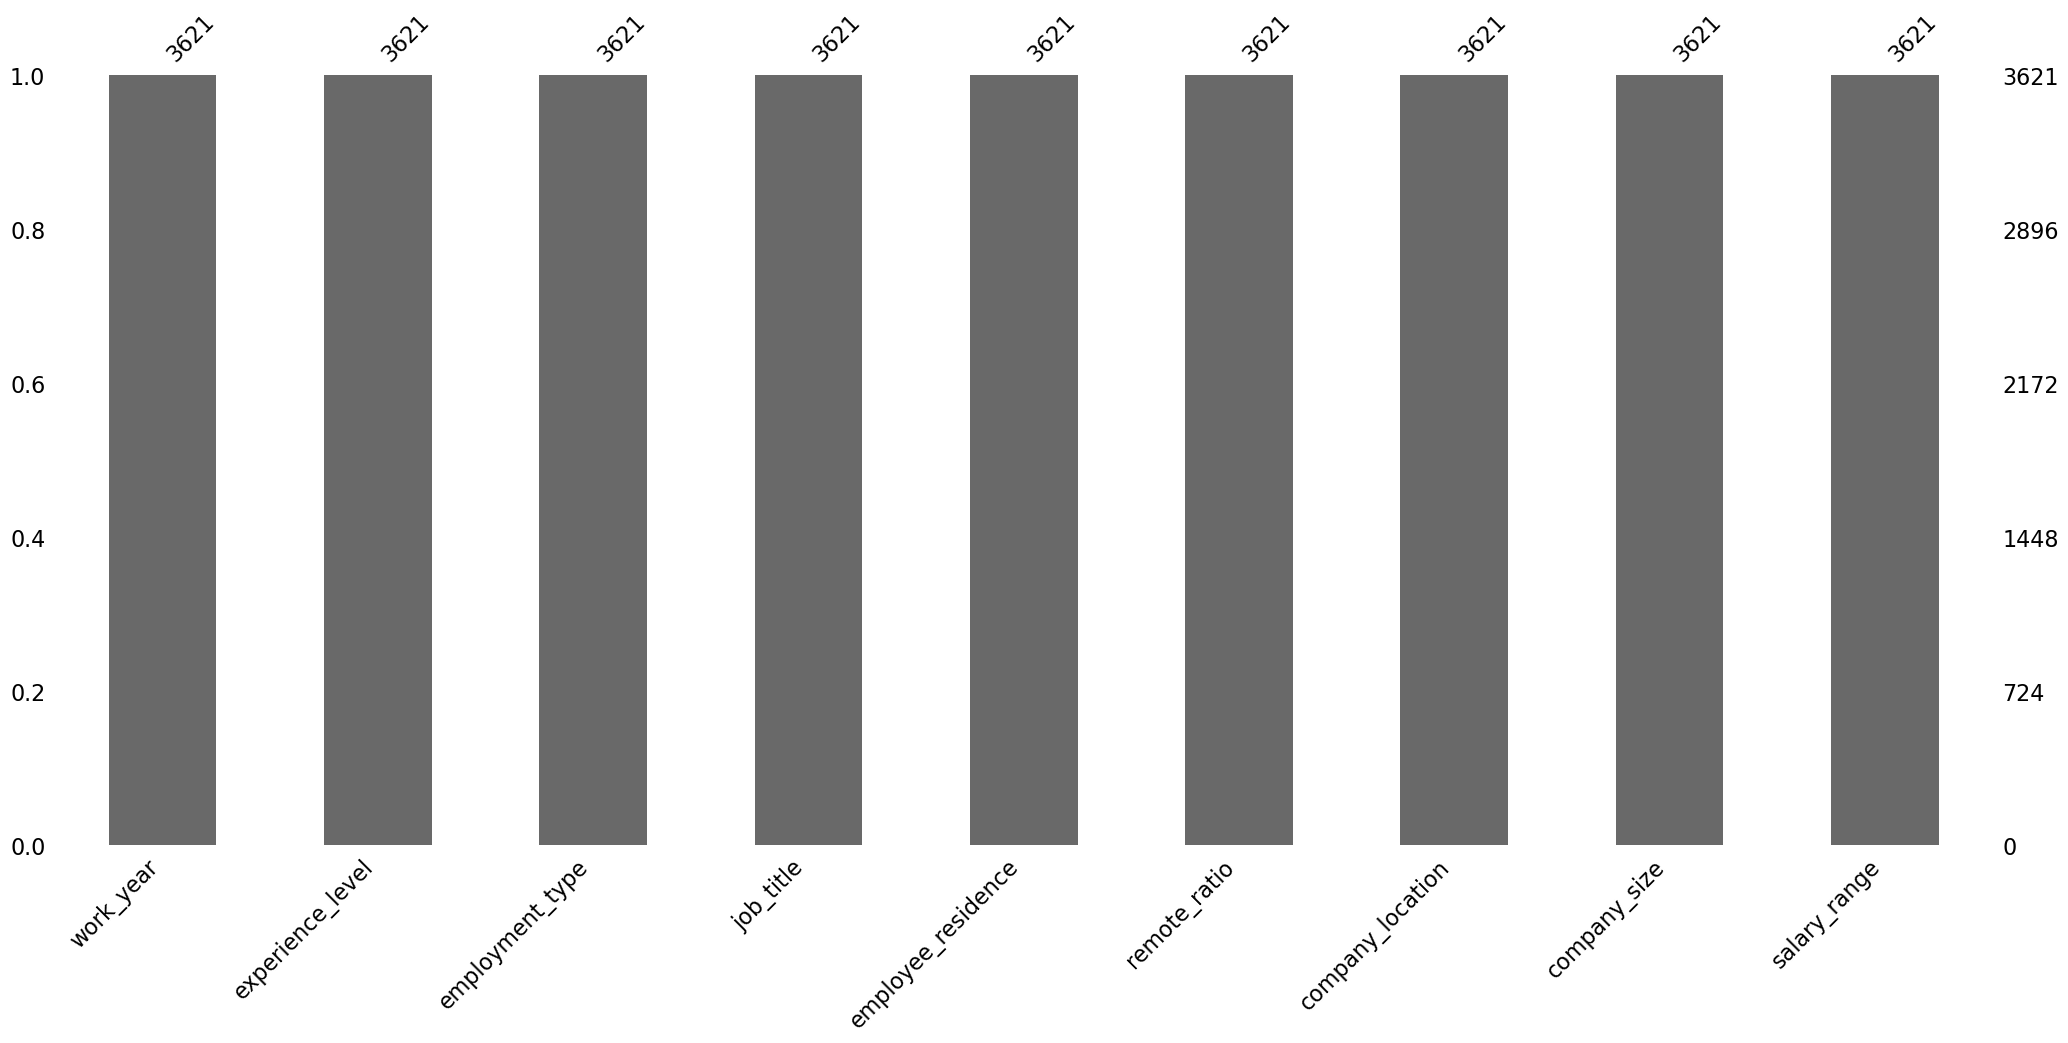

In [35]:
msno.bar(df)

In [36]:
# Split the df dataframe into two dataframes : df_train and df_added (1000 lines in df_added, the rest in df_train. Chose lines randomly)
df_added = df.sample(1000)
df_train = df.drop(df_added.index)

df_added.to_csv('data/ds_salaries_added.csv', index=False)
df_train.to_csv('data/ds_salaries_train.csv', index=False)

In [37]:
with mlflow.start_run(run_name="data_preprocessing"):
    mlflow.log_artifact("data/ds_salaries.csv", artifact_path="raw_data")
    mlflow.log_artifact("data/ds_salaries_train.csv", artifact_path="processed_data")
    mlflow.log_artifact("data/ds_salaries_added.csv", artifact_path="processed_data")

In [38]:
# We now focus on the train dataset
df = pd.read_csv('data/ds_salaries_train.csv')

In [39]:
# Remove variables df_added and df_train
del df_added, df_train

In [40]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2621 entries, 0 to 2620
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   work_year           2621 non-null   int64 
 1   experience_level    2621 non-null   object
 2   employment_type     2621 non-null   object
 3   job_title           2621 non-null   object
 4   employee_residence  2621 non-null   object
 5   remote_ratio        2621 non-null   int64 
 6   company_location    2621 non-null   object
 7   company_size        2621 non-null   object
 8   salary_range        2621 non-null   int64 
dtypes: int64(3), object(6)
memory usage: 184.4+ KB


In [41]:
df.sample(10)

,work_year,experience_level,employment_type,job_title,employee_residence,remote_ratio,company_location,company_size,salary_range
1641,2022,MI,FT,Data Engineer,US,100,US,M,12
2145,2022,SE,FT,Data Engineer,US,0,US,M,13
2194,2022,EN,FT,Data Analyst,FR,50,FR,M,2
1531,2022,SE,FT,Data Engineer,CA,0,CA,M,16
1406,2022,MI,FT,Data Engineer,US,100,US,M,7
395,2023,MI,FT,Data Engineer,US,0,US,M,9
1095,2023,EN,FT,Business Data Analyst,GR,50,GR,L,1
1927,2022,SE,FT,ETL Developer,US,100,US,M,5
454,2023,SE,FT,Data Engineer,US,0,US,M,12
707,2023,SE,FT,Data Analyst,US,100,US,M,10


In [42]:
# Séparer les features (X) et la target (y)
X = df.drop('salary_range', axis=1)
y = df['salary_range']

In [43]:
# Définir les colonnes catégorielles
cat_cols = ['experience_level', 'employment_type', 'job_title', 'employee_residence', 'company_location', 'company_size']

# Créer l'objet OneHotEncoder
ohe = OneHotEncoder(handle_unknown='ignore')

# Créer le ColumnTransformer
ct = ColumnTransformer(transformers=[('encoder', ohe, cat_cols)], remainder='passthrough')

# Appliquer la transformation à X
X_encoded = ct.fit_transform(X)

In [44]:
# transform numeric columns to normalised values
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler(with_mean=False)
X_encoded = scaler.fit_transform(X_encoded)

In [45]:
#y_normalized = y / y.max()

In [46]:
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

In [47]:
from xgboost import XGBRegressor
model = XGBRegressor(n_estimators=100, learning_rate=0.1)
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [48]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
y_pred = model.predict(X_test)
rmse = root_mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

In [49]:
# print model performance
print('RMSE: {:.2f}'.format(rmse))
print('MAE: {:.2f}'.format(mae))
print('R^2: {:.2f}'.format(r2))

RMSE: 4.55
MAE: 3.39
R^2: 0.28


### Avec une version "naive" de xgboost, le score n'est pas bon. Il va falloir optimiser les hyperparamètres.

## GridsearchCV avec XGBoost

In [50]:
param_grid_xgb = {
    'max_depth': [2,3,4,5,6,7],
    'learning_rate': [0.05,0.06,0.07,0.08,0.09],
    'n_estimators': [200,300,400,500],
}


In [51]:
grid_search_xgb = GridSearchCV(estimator=XGBRegressor(objective='reg:squarederror'), 
                           param_grid=param_grid_xgb,
                           cv=5,  # 5-fold cross-validation
                           n_jobs=-1,  # utiliser tous les CPU
                           verbose=2)  # afficher les logs


In [52]:
grid_search_xgb.fit(X_train, y_train)


Fitting 5 folds for each of 120 candidates, totalling 600 fits


GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=None, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.05, 0.06, 0.07, 0.08, 0.09],
                         'max_depth': [2, 3, 4, 5, 6, 7],
                         'n_estimators': [200, 300, 400, 500]},
             verbose=2)

In [53]:
print(f"Meilleurs hyperparamètres : {grid_search_xgb.best_params_}")
print(f"Meilleur score de validation croisée : {grid_search_xgb.best_score_:.4f}")

Meilleurs hyperparamètres : {'learning_rate': 0.07, 'max_depth': 2, 'n_estimators': 500}
Meilleur score de validation croisée : 0.3814


In [54]:
y_pred = grid_search_xgb.predict(X_test)
print(f"RMSE sur l'ensemble de test : {root_mean_squared_error(y_test, y_pred):.2f}")

RMSE sur l'ensemble de test : 4.46


In [55]:
rmse = root_mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# print model performance
print('RMSE: {:.2f}'.format(rmse))
print('MAE: {:.2f}'.format(mae))
print('R^2: {:.2f}'.format(r2))

RMSE: 4.46
MAE: 3.36
R^2: 0.31


In [56]:
# select best model
best_model_xgb = grid_search_xgb.best_estimator_

In [57]:
with mlflow.start_run():
    mlflow.log_params(grid_search_xgb.best_params_)
    mlflow.log_metric("rmse", rmse)
    mlflow.log_metric("mae", mae)  
    mlflow.log_metric("r2", r2)
    mlflow.xgboost.log_model(best_model_xgb, "model")

c:\Users\GRETA\anaconda3\envs\mlops\Lib\site-packages\xgboost\core.py:160: UserWarning: [14:46:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)


## GridSearchCV Random Forest

In [58]:
# show how many features exist on X_train
print(X_train.shape)

(2096, 216)


In [59]:
param_grid_rf = { 
    'n_estimators': [90,100,110],
    'max_features': [35,40,45],
    'max_depth' : [13,14,15],
    'criterion' :['squared_error']
}

In [60]:
rf = RandomForestRegressor()
grid_search_rf = GridSearchCV(estimator=rf, param_grid=param_grid_rf, 
                           cv=5, n_jobs=-1, verbose=2)

In [61]:
grid_search_rf.fit(X_train, y_train)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


GridSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'criterion': ['squared_error'],
                         'max_depth': [13, 14, 15],
                         'max_features': [35, 40, 45],
                         'n_estimators': [90, 100, 110]},
             verbose=2)

In [62]:
print(f"Best parameters: {grid_search_rf.best_params_}")  
print(f"Best cross-validation score: {grid_search_rf.best_score_:.4f}")

Best parameters: {'criterion': 'squared_error', 'max_depth': 15, 'max_features': 35, 'n_estimators': 100}
Best cross-validation score: 0.3834


In [63]:
y_pred = grid_search_rf.predict(X_test)
print(f"RMSE on test set: {root_mean_squared_error(y_test, y_pred):.2f}")

RMSE on test set: 4.57


In [64]:
rmse = root_mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# print model performance
print('RMSE: {:.2f}'.format(rmse))
print('MAE: {:.2f}'.format(mae))
print('R^2: {:.2f}'.format(r2))

RMSE: 4.57
MAE: 3.41
R^2: 0.28


In [65]:
# select the best model
best_model_rf = grid_search_rf.best_estimator_

In [66]:
with mlflow.start_run():
    mlflow.log_params(grid_search_rf.best_params_)
    mlflow.log_metric("rmse", rmse)
    mlflow.log_metric("mae", mae)  
    mlflow.log_metric("r2", r2)
    mlflow.sklearn.log_model(best_model_rf, "modelrf")

c:\Users\GRETA\anaconda3\envs\mlops\Lib\site-packages\_distutils_hack\__init__.py:11: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
c:\Users\GRETA\anaconda3\envs\mlops\Lib\site-packages\_distutils_hack\__init__.py:26: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


## SVR

In [67]:
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV

param_grid_svr = {
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'C': [0.010,0.011,0.012],
    'epsilon': [2.49,2.5,2.51]
}

svr = SVR()
grid_search_svr = GridSearchCV(estimator=svr, param_grid=param_grid_svr, 
                           cv=5, n_jobs=-1, verbose=2)

grid_search_svr.fit(X_train, y_train)


Fitting 5 folds for each of 36 candidates, totalling 180 fits


GridSearchCV(cv=5, estimator=SVR(), n_jobs=-1,
             param_grid={'C': [0.01, 0.011, 0.012],
                         'epsilon': [2.49, 2.5, 2.51],
                         'kernel': ['linear', 'poly', 'rbf', 'sigmoid']},
             verbose=2)

In [68]:
print(f"Best parameters: {grid_search_svr.best_params_}")  
print(f"Best cross-validation score: {grid_search_svr.best_score_:.4f}")

Best parameters: {'C': 0.012, 'epsilon': 2.5, 'kernel': 'linear'}
Best cross-validation score: 0.3701


In [69]:
y_pred = grid_search_svr.predict(X_test)
print(f"RMSE on test set: {root_mean_squared_error(y_test, y_pred):.2f}")

RMSE on test set: 4.42


In [70]:
rmse = root_mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# print model performance
print('RMSE: {:.2f}'.format(rmse))
print('MAE: {:.2f}'.format(mae))
print('R^2: {:.2f}'.format(r2))

RMSE: 4.42
MAE: 3.33
R^2: 0.32


In [71]:
# select the best model
best_model_svr = grid_search_svr.best_estimator_

In [72]:
with mlflow.start_run():
    mlflow.log_params(grid_search_svr.best_params_)
    mlflow.log_metric("rmse", rmse)
    mlflow.log_metric("mae", mae)  
    mlflow.log_metric("r2", r2)
    mlflow.sklearn.log_model(best_model_svr, "modelsvr")

c:\Users\GRETA\anaconda3\envs\mlops\Lib\site-packages\_distutils_hack\__init__.py:11: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
c:\Users\GRETA\anaconda3\envs\mlops\Lib\site-packages\_distutils_hack\__init__.py:26: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
